# Lab 1: Configuring & Running Experiments in SimBricks

## 1. Minimal 2-Host Experiment
To get started, we will set up a simple experiment with two hosts that have one NIC each and are connected through a basic switch. The hosts run Linux with the regular network stack, and run the standard `iperf` network benchmark, with one hosts acting as the server, and the other as the client.

To keep simulation times low for testing here, we use unsynchronized and inaccurate simulator configurations: QEMU with KVM acceleration (if available), the behavioral Intel x710 (`i40e`) NIC model, and our simple behavioral switch.

### 1.1. Specifying Simulation Configuration
Now let's set up this configuration in the SimBricks orchestration framework:

The first step is to create an `Experiment` object. This object contains pointers to all relevant components in the simulation and an instance serves as a declarative description of the configuration.

In [1]:
import simbricks.experiments as exp
import simbricks.simulators as sim
import simbricks.nodeconfig as node

e = exp.Experiment('my-simple-experiment')

Now we instantiate the first Component simulator, the `SwitchNet` behavioral switch model, and add it to our experiment object.

In [2]:
net = sim.SwitchNet()
e.add_network(net)

Next we create the first instance of the QEMU host simulator for the server and label it accordingly.

In [3]:
server = sim.QemuHost()
server.name = 'server'

For each host simulator we also have to specify what software to run through a *node configuration object*. This basically specifies which disk image to use, and includes a set of commands to run after boot, for steps including loading NIC drivers, assigning IP addresses, and other configuration steps. Here we use the `I40eLinuxNode` configuration, which will load the `i40e` NIC driver, and assign the IP address specified.

In [4]:
server_config = node.I40eLinuxNode()
server.set_config(server_config)
server_config.prefix = 24
server_config.ip = '10.0.0.1'

The node configuration also points to the *application configuration*, specifying the actual workload, i.e. commands to run after the system is fully booted up. These objects mostly just provide a bit of syntactic sugar to make it easier to set benchmark configuration parameters in a readable way from python.

In [5]:
server_config.app = node.IperfTCPServer()

After configuring the server host simulator, we add an instance of the `i40e` NIC model, and connect it to both the host simulator and our switch simulator. As a last step for the server, we add the NIC and host to the experiment object.

In [6]:
server_nic = sim.I40eNIC()
server_nic.set_network(net)
server.add_nic(server_nic)

e.add_nic(server_nic)
e.add_host(server)

Finally, we repeat the same steps for the client, with two small differences: First, we set the wait attribute on the client host simulator, to indicate that we want to wait for this simulator to terminate before stopping the experiment (many simulators, for the server, NICs, and networks, typically run until they are manually stopped when the experiment is finished).

In [7]:
# Create host simulator for client
client = sim.QemuHost()
client.name = 'client'
client.wait = True  # Wait for client to shut down before ending experiment

# Node configuration describes software configuration running on the client
client_config = node.I40eLinuxNode()
client_config.prefix = 24
client_config.ip = '10.0.0.2'

Second, for the client we specify a different application configuration to run the iperf client instead of the server, and pass it the server IP address to connect to.

In [8]:
client_config.app = node.IperfTCPClient()
client_config.app.server_ip = '10.0.0.1'  # Client needs to know server IP
client.set_config(client_config)

# Create nic simulator for client
client_nic = sim.I40eNIC()
client_nic.set_network(net)
client.add_nic(client_nic)

e.add_nic(client_nic)
e.add_host(client)

And that's it! We have assembled our first SimBricks simulation configuration. Here is a simple illustration of what we have assembled:

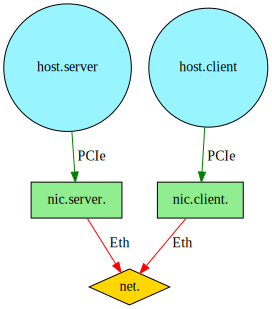

In [9]:
import visualize

visualize.experiment_graph(e)

### 1.2. Running the Simulation

Now that we have assembled our simulation, the next step is running it. Typically we would save the experiment to a `.py` file, and then use the `run.py` script and run it from the terminal. (Details on how to do that below.) Here we will directly use our python orchestration mechanisms to run a simple local experiment.

For this we first specify the `LocalExecutor` to run our simulation locally directly by starting the commands from the python process. (other executors execute component simulators on remote hosts, particularly useful for distributed simulations spanning multiple hosts)

In [10]:
import simbricks.experiments as exp
import simbricks.exectools as exectools
import simbricks.runtime as runtime

executor = exectools.LocalExecutor()

Next, we set up an experiment environment, which specifies paths for simulator executables, unix sockets, shared memory regions, working copies of simulator disk images, and other working files of different component simulators. Here we just pass in the path to our SimBricks repo and a new working directory for this experiment. For the rest the `ExpEnv` has sensible defaults that can be customized if necessary.

In [11]:
workdir = './out/lab1_test1'
env = exp.ExpEnv(repo_path='/simbricks', workdir=workdir, cpdir=workdir)
#env.create_cp = False # FIXME: should not be needed
#env.pcap_file = '' # FIXME: shoult not be needed

Now we create a `Run` object, which is intended for a single execution of an experiment, and stores the experiment, and the environment. For the run we then initialize the output and working directory.

In [12]:
run = runtime.Run(experiment=e, index=0, env=env, outpath=workdir, prereq=None)
await run.prep_dirs(executor)

Finally, we create a runner responsible for orchestrating the simulation run. The execution results in an output object that contains all simulator outputs, commands, executed, timestamps, and other metadata for the run. We create the runner with the verbose flag set here, so we also see the output on the console as the simulation executes, helpful for debugging but all this information is also contained in the output object.

In [13]:
runner = exp.ExperimentSimpleRunner(exec=executor, exp=e, env=env, verbose=True)
await runner.prepare()
output = await runner.run()

preparing config tar: /simbricks/labs/out/lab1_test1/cfg.server.tar
preparing config tar: /simbricks/labs/out/lab1_test1/cfg.client.tar
prepare_my-simple-experiment.0 ERR: ['qemu-img: warning: Deprecated use of backing file without explicit backing format (detected format of qcow2)']
prepare_my-simple-experiment.0 ERR: ['qemu-img: warning: Deprecated use of backing file without explicit backing format (detected format of qcow2)']
prepare_my-simple-experiment.0 OUT: ["Formatting '/simbricks/labs/out/lab1_test1/hdcopy.server', fmt=qcow2 cluster_size=65536 extended_l2=off compression_type=zlib size=42949672960 backing_file=/simbricks/images/output-base/base backing_fmt=qcow2 lazy_refcounts=off refcount_bits=16"]
prepare_my-simple-experiment.0 OUT: ["Formatting '/simbricks/labs/out/lab1_test1/hdcopy.client', fmt=qcow2 cluster_size=65536 extended_l2=off compression_type=zlib size=42949672960 backing_file=/simbricks/images/output-base/base backing_fmt=qcow2 lazy_refcounts=off refcount_bits=1

#### Runing Simulations from the Terminal
To run the same simulation from the terminal, we would save the experiment configuration to  a `.py` file, which has to contain a list `experiments` of all experiment configurations in the file (here `experiments = [e]` at the bottom of the file would suffice):

In [14]:
import IPython


def display_source(code):

    def _jupyterlab_repr_html_(self):
        from pygments import highlight
        from pygments.formatters import HtmlFormatter

        fmt = HtmlFormatter()
        style = "<style>{}\n{}</style>".format(
            fmt.get_style_defs(".output_html"),
            fmt.get_style_defs(".jp-RenderedHTML")
        )
        return style + highlight(self.data, self._get_lexer(), fmt)

    # Replace _repr_html_ with our own version that adds the 'jp-RenderedHTML' class
    # in addition to 'output_html'.
    IPython.display.Code._repr_html_ = _jupyterlab_repr_html_
    return IPython.display.Code(data=code, language="python3")


with open('lab1_test2.py', 'r') as f:
    test2_src = f.read()

display_source(test2_src)

import simbricks.experiments as exp
import simbricks.simulators as sim
import simbricks.nodeconfig as node

e = exp.Experiment('lab1_test2')

net = sim.SwitchNet()
e.add_network(net)


server = sim.QemuHost()
server.name = 'server'

server_config = node.I40eLinuxNode()
server.set_config(server_config)
server_config.prefix = 24
server_config.ip = '10.0.0.1'

server_config.app = node.IperfTCPServer()

server_nic = sim.I40eNIC()
server_nic.set_network(net)
server.add_nic(server_nic)

e.add_nic(server_nic)
e.add_host(server)


# Create host simulator for client
client = sim.QemuHost()
client.name = 'client'
client.wait = True # Wait for client to shut down before ending experiment

# Node configuration describes software configuration running on the client
client_config = node.I40eLinuxNode()
client_config.prefix = 24
client_config.ip = '10.0.0.2'

client_config.app = node.IperfTCPClient()
client_config.app.server_ip = '10.0.0.1' # Client needs to know server IP
client.set_config(client_config)

# Create nic simulator for client
client_nic = sim.I40eNIC()
client_nic.set_network(net)
client.add_nic(client_nic)

e.add_nic(client_nic)
e.add_host(client)

experiments = [e]

This file can then be passed to the `run.py` script in the `experiments` directory of the simbricks repo. Assuming we save it as `my-simple-experiment.py` we would run this simulation with `python3 /simbricks/experiments/run.py --verbose`. By default `run.py` will use `out/EXPERIMENT-NAME/N` as the working directory for the Nth run of an experiment, and store the output in json format as `out/EXPERIMENT-NAME-N.json`. If the json file for a run already exists execution of that run is skipped unless `--force` is also specified.

In [24]:
import os

os.system('simbricks-run --verbose --force lab1_test2.py')


preparing config tar: /simbricks/labs/out/lab1_test2/1/cfg.server.tar
preparing config tar: /simbricks/labs/out/lab1_test2/1/cfg.client.tar
prepare_lab1_test2.0 ERR: ['qemu-img: warning: Deprecated use of backing file without explicit backing format (detected format of qcow2)']
prepare_lab1_test2.0 OUT: ["Formatting '/simbricks/labs/out/lab1_test2/1/hdcopy.client', fmt=qcow2 cluster_size=65536 extended_l2=off compression_type=zlib size=42949672960 backing_file=/simbricks/images/output-base/base backing_fmt=qcow2 lazy_refcounts=off refcount_bits=16"]
prepare_lab1_test2.0 ERR: ['qemu-img: warning: Deprecated use of backing file without explicit backing format (detected format of qcow2)']
prepare_lab1_test2.0 OUT: ["Formatting '/simbricks/labs/out/lab1_test2/1/hdcopy.server', fmt=qcow2 cluster_size=65536 extended_l2=off compression_type=zlib size=42949672960 backing_file=/simbricks/images/output-base/base backing_fmt=qcow2 lazy_refcounts=off refcount_bits=16"]
prepare_lab1_test2.0 TERMINA

0

The experiment output is now stored in `out/lab1_test2-1.json` as json from where we later load it for processing:

In [25]:
output_2 = exp.ExpOutput(e) # TODO: refactor so this does not take e as a parameter!
with open('out/lab1_test2-1.json', 'r') as f:
    s = f.read()
    output_2.loads(s)

### 1.3. Processing the Output
After running a simulation, the `ExpOutput` objects contain timestamps for when the simulation started and stopped, the commands executed for each simulator, and per-simulator output, including the console for host simulator, as well as additional metadata. For long running simulations in particular, we recommend first running simulations and storing the output to json files (through `run.py` or by calling `ExpOutput.dumps()` from python), and post-processing the obtained data in a separate step. This avoids having to re-run potentially long-running simulations when tweaking the post processing.

Below is a simple post-processing example parsing the `iperf` throughput from the output of the two simulations run above:

In [26]:
import re


# Parse iperf throughput for specified host from output
def parse_iperf_throughput(output: exp.ExpOutput, host: sim.HostSim) -> float:
    # Regex to match output lines from iperf client
    tp_pat = re.compile(
        r'\[ *\d*\] *([0-9\.]*)- *([0-9\.]*) sec.*Bytes *([0-9\.]*) ([GM])bits.*'
    )
    throughputs = []
    # iterate through host output
    for l in output.sims[host.full_name()]['stdout']:
        m = tp_pat.match(l)
        if not m:
            continue
        if m.group(4) == 'G':
            throughputs.append(float(m.group(3)))
        elif m.group(4) == 'M':
            throughputs.append(float(m.group(3)) / 1000)
    return sum(throughputs) / len(throughputs)


print(
    'Throughput test 1: %.2f Gbps\nSimulation time: %.2fs\n' % (
        parse_iperf_throughput(output, client),
        output.end_time - output.start_time
    )
)
print(
    'Throughput test 2: %.2f Gbps\nSimulation time: %.2f' % (
        parse_iperf_throughput(output_2, client),
        output_2.end_time - output_2.start_time
    )
)


Throughput test 1: 0.30 Gbps
Simulation time: 43.47s

Throughput test 2: 0.49 Gbps
Simulation time: 39.47


## 2. Configuring more Complex Simulations

*TODO: discuss how to do things like parameter sweeps with multiple experiments, use python features like loops or functions to generate*

## 3. Running Distributed Simulations
Might include this as a separate lab as it requires at least two containers.